<a href="https://colab.research.google.com/github/klajosw/python/blob/master/kl_py_map_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p align="left"> 
    <img src="https://raw.githubusercontent.com/klajosw/python/master/kl_mie_python_logo_250.jpg" 
         align="left" width="251" height="251">
    
</p>


<p> </p>

# Térképi megjelenítése Python programmal


## osmnx és networkx használata

<https://klajosw.blogspot.com/>


---


In [ ]:
import networkx as nx
import osmnx as ox
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from descartes import PolygonPatch
from shapely.geometry import Polygon, MultiPolygon
%matplotlib inline
ox.config(use_cache=True, log_console=True)
## ox.__version__

---
### Település körvonal/kontur
---

Gyál  (szürke)
Pécs  (piros)
Tárnok (Kék)


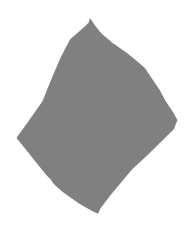

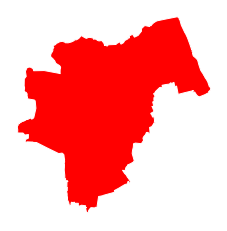

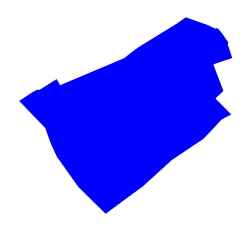

In [ ]:
# Település kontur kirajzolása

gdf1 = ox.geocode_to_gdf('Gyál, Hungary')
gdf2 = ox.geocode_to_gdf('Pécs, Hungary')
gdf3 = ox.geocode_to_gdf('Tárnok, Hungary')

print('Gyál  (szürke)')
mx_gt_tx = ox.project_gdf(gdf1)
ax = mx_gt_tx.plot(fc='gray', ec='w')
_ = ax.axis('off')

print('Pécs  (piros)')
mx_gt_tx = ox.project_gdf(gdf2)
ax = mx_gt_tx.plot(fc='red', ec='w')
_ = ax.axis('off')

print('Tárnok (Kék)')
mx_gt_tx = ox.project_gdf(gdf3)
ax = mx_gt_tx.plot(fc='blue', ec='w')
_ = ax.axis('off')

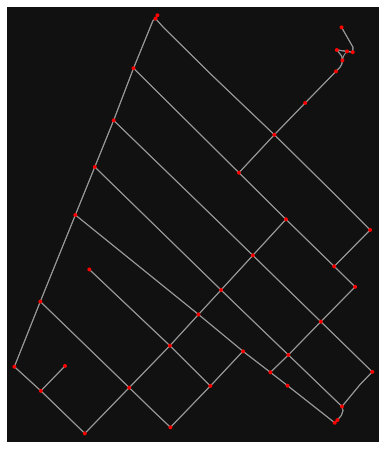

In [ ]:
## Pozico kordináta megadása
point = 47.384983,19.2009673  ## Gyál
G = ox.graph_from_point(point, network_type='drive', dist=500)
fig, ax = ox.plot_graph(G, node_color='r')

In [ ]:
G_proj = ox.project_graph(G)
intersections = ox.consolidate_intersections(G_proj, rebuild_graph=False, tolerance=15, dead_ends=False)
len(intersections)

33

---

### Utvonal térkép és sarkok mint pontok

---

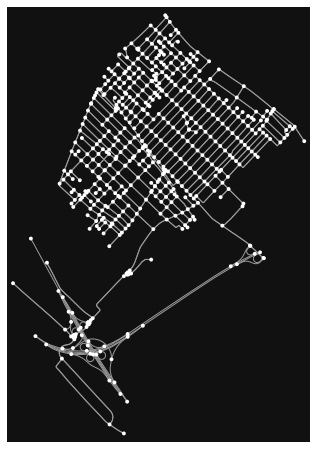

In [ ]:
# Gyál város megjelenítése
G = ox.graph_from_place('Gyál, Hungary', network_type='drive')
fig, ax = ox.plot_graph(G)

In [ ]:
# milyen méretű területet fed le a térkép négyzetméterben?
G_proj = ox.project_graph(G)
nodes_proj = ox.graph_to_gdfs(G_proj, edges=False)
graph_area_m = nodes_proj.unary_union.convex_hull.area
print('Térkép területe :',graph_area_m,' (m2)')

Térkép területe : 17313634.99437639  (m2)


In [ ]:
# Alap statisztika  // Értelemezése : https://osmnx.readthedocs.io/en/stable/osmnx.html#module-osmnx.stats
ox.basic_stats(G_proj, area=graph_area_m, clean_intersects=True, circuity_dist='euclidean')

{'n': 538,
 'm': 1517,
 'k_avg': 5.639405204460966,
 'intersection_count': 482,
 'streets_per_node_avg': 3.046468401486989,
 'streets_per_node_counts': {0: 0, 1: 56, 2: 0, 3: 345, 4: 137},
 'streets_per_node_proportion': {0: 0.0,
  1: 0.10408921933085502,
  2: 0.0,
  3: 0.6412639405204461,
  4: 0.25464684014869887},
 'edge_length_total': 245871.9269999999,
 'edge_length_avg': 162.07773698088326,
 'street_length_total': 137276.40700000004,
 'street_length_avg': 170.31812282878417,
 'street_segments_count': 806,
 'node_density_km': 31.073775101227834,
 'intersection_density_km': 27.83933010927847,
 'edge_density_km': 14201.057552608745,
 'street_density_km': 7928.803341677732,
 'circuity_avg': 1.0155686389936562,
 'self_loop_proportion': 0.0,
 'clean_intersection_count': 427,
 'clean_intersection_density_km': 24.662643063613913}

In [ ]:
# Térkép mentése geopackage (GIS vagy graphml  formába további feldolgozásra pl.: gephi ...)
ox.save_graph_geopackage(G, filepath='gyal.gpkg')
ox.save_graphml(G, filepath='gyal.graphml')

---

## Városok utcáinak megjelenítése


### út tipusok

Ábrázolhatjuk az utcai hálózatot és színezzük annak széleit (utcáit) a viszonylagos közelségük szerint.


'drive'         - get drivable public streets (but not service roads)

'drive_service' - get drivable streets, including service roads

'walk'          - get all streets and paths that pedestrians can use (this network type ignores one-way directionality)

'bike'          - get all streets and paths that cyclists can use

'all'           - download all non-private OSM streets and paths (this is the default network type unless you specify a different one)

'all_private'   - download all OSM streets and paths, including private-access ones


---

In [ ]:
# konvertáljuk a gráfot vonalas gráfra, hogy az élek csomópontokká váljanak, és fordítva

edge_centrality = nx.closeness_centrality(nx.line_graph(G))
nx.set_edge_attributes(G, edge_centrality, 'edge_centrality')

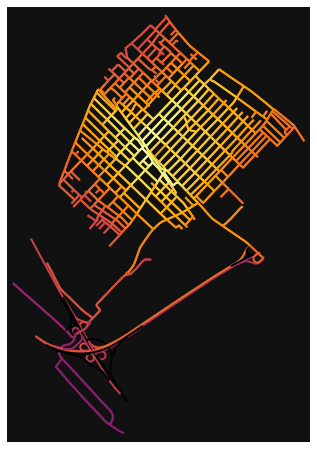

In [ ]:
# színes élek az eredeti grafikonról, a közelség a vonaldiagramról 
ec = ox.plot.get_edge_colors_by_attr(G, 'edge_centrality', cmap='inferno')
fig, ax = ox.plot_graph(G, edge_color=ec, edge_linewidth=2, node_size=0)

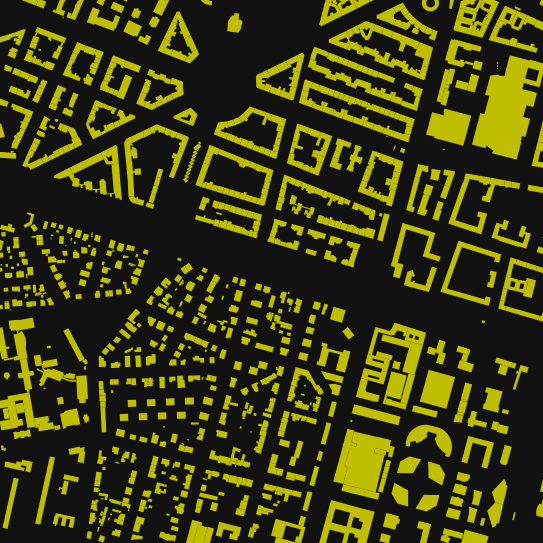

In [ ]:
## Budapest, Magyar ország)
point =  (47.471638,19.0422459) ## Halászbástya
dist = 612
gdf = ox.footprints.footprints_from_point(point=point, dist=dist)
gdf_proj = ox.project_gdf(gdf)
bbox = ox.utils_geo.bbox_from_point(point=point, dist=dist, project_utm=True)
fp = f'./{img_folder}/BP_halaszb_bldgs.{extension}'
fig, ax = ox.plot_footprints(gdf_proj, bbox=bbox, color='y', filepath=fp, dpi=90,
                             save=True, show=False, close=True)
Image(fp, height=size, width=size)

---

## Útvonal tervezés

---

In [ ]:
# Gyál város megjelenítése
G = ox.graph_from_place('Gyál, Hungary', network_type='drive')
# sebesség és menet idő figyelembe vétele
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

In [ ]:
# Gyál Pozsonyi utca 39 és a Kakucsi Pékség Kft távolság
orig = ox.get_nearest_node(G, (47.384983,19.2009673))
dest = ox.get_nearest_node(G, (47.37571,19.2196368))

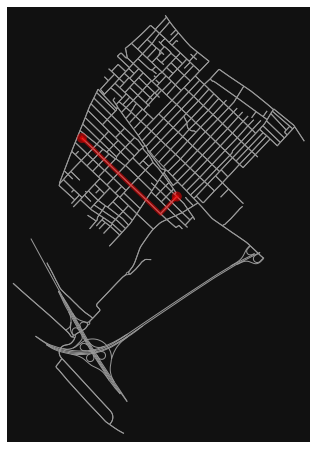

In [ ]:
# legrövidebb idelyű utvonal keresés és megjelenítés
route = nx.shortest_path(G, orig, dest, weight='travel_time')
fig, ax = ox.plot_graph_route(G, route, node_size=0)

In [ ]:
# Milyen hosszú a megtett út
edge_lengths = ox.utils_graph.get_route_edge_attributes(G, route, 'length')
print('Út hossza: ', sum(edge_lengths), 'm')

Út hossza:  2106.807 m


In [ ]:
# Légvonalbani távolság mennyi?
lv_hossz=ox.distance.great_circle_vec(G.nodes[orig]['y'], G.nodes[orig]['x'],
                             G.nodes[dest]['y'], G.nodes[dest]['x'])
print('Légvonalban: ', lv_hossz, 'm')


Légvonalban:  1767.9295727226952 m


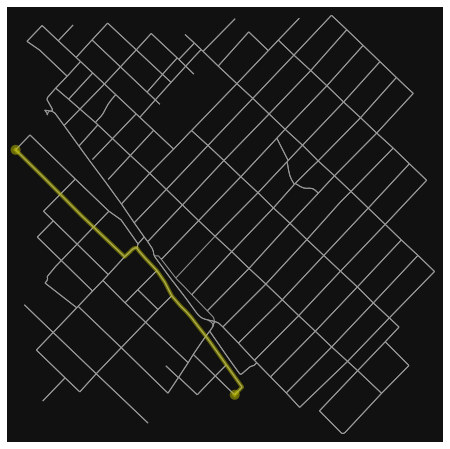

In [ ]:
G2 = ox.graph_from_address('Gyál, Hungary', dist=800, network_type='drive', truncate_by_edge=True)
# Gyál Pozsonyi utca 39 és a Kakucsi Pékség Kft távolság
origin = (47.384983,19.2009673)
destination = (47.37571,19.2196368)

origin_node = ox.get_nearest_node(G2, origin)
destination_node = ox.get_nearest_node(G2, destination)
route = nx.shortest_path(G2, origin_node, destination_node)
fig, ax = ox.plot_graph_route(G2, route, route_color='y', node_size=0)

In [ ]:
## sebesség adatok használata, utvonalak idejének figyelembevételénél

G2 = ox.add_edge_speeds(G2)
G2 = ox.add_edge_travel_times(G2)

# úttipusonkénti adatok listázása
edges = ox.graph_to_gdfs(G2, nodes=False)
edges['highway'] = edges['highway'].astype(str)
edges.groupby('highway')[['length', 'speed_kph', 'travel_time']].mean().round(1)


,length,speed_kph,travel_time
highway,,,
residential,150.1,50.0,10.8
secondary,113.6,50.0,8.2
tertiary,124.6,50.0,9.0


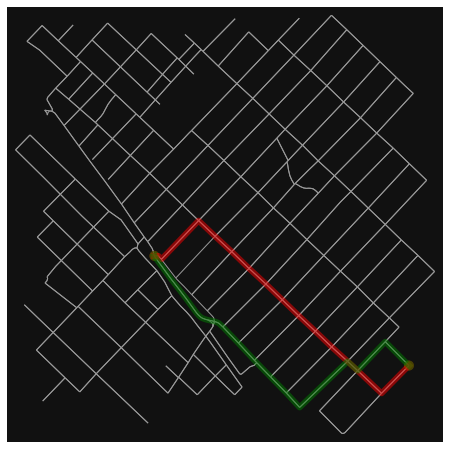

In [ ]:
## újra tervezés értékek módosítása után
hwy_speeds = {'residential': 35,
              'secondary': 50,
              'tertiary': 60}
G2 = ox.add_edge_speeds(G2, hwy_speeds)
G2 = ox.add_edge_travel_times(G2)

## Két útvonal tervezése legrövidebb út és legrüvidebb menetidővel
orig = list(G2)[1]
dest = list(G2)[-1]
route1 = nx.shortest_path(G2, orig, dest, weight='length')
route2 = nx.shortest_path(G2, orig, dest, weight='travel_time')

# plot the routes
fig, ax = ox.plot_graph_routes(G2, routes=[route1, route2], route_colors=['r', 'g'],  route_linewidth=6, node_size=0)

In [ ]:
G=G2
route1_length = int(sum(ox.utils_graph.get_route_edge_attributes(G, route1, 'length')))
route2_length = int(sum(ox.utils_graph.get_route_edge_attributes(G, route2, 'length')))
route1_time = int(sum(ox.utils_graph.get_route_edge_attributes(G, route1, 'travel_time')))
route2_time = int(sum(ox.utils_graph.get_route_edge_attributes(G, route2, 'travel_time')))
print(' 1. -es útvonal ', route1_length, ' méter és a megtételhez szükséges idő ', route1_time, ' másodperc.')
print(' 2. -es útvonal ', route2_length, ' méter és a megtételhez szükséges idő ', route2_time, ' másodperc.')

 1. -es útvonal  1638  méter és a megtételhez szükséges idő  168  másodperc.
 2. -es útvonal  1703  méter és a megtételhez szükséges idő  138  másodperc.


---

### Település pontok színezése a település középponttól való távolság arányában

---

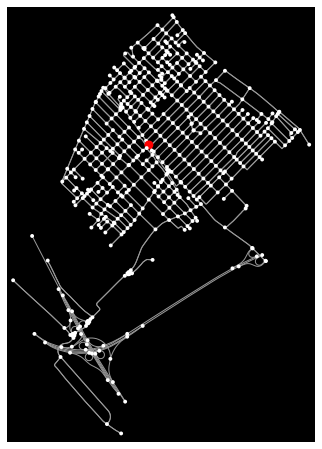

In [ ]:
# Gyál város megjelenítése a központtal
G = ox.graph_from_place('Gyál, Hungary', network_type='drive')
gdf = ox.geocode_to_gdf('Gyál, Hungary')
area = ox.project_gdf(gdf).unary_union.area
stats = ox.basic_stats(G, area=area)
extended_stats = ox.extended_stats(G, ecc=True, bc=True, cc=True)

G_projected = ox.project_graph(G)
max_node, max_bc = max(extended_stats['betweenness_centrality'].items(), key=lambda x: x[1])
max_node, max_bc

nc = ['r' if node==max_node else 'w' for node in G_projected.nodes()]
ns = [80 if node==max_node else 15 for node in G_projected.nodes()]
fig, ax = ox.plot_graph(G_projected, node_size=ns, node_color=nc, node_zorder=2, bgcolor='k')

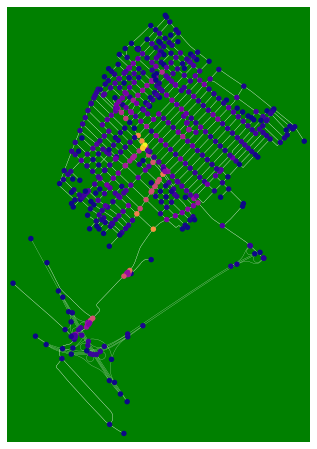

In [ ]:
## központhoz képesti távolság sulyozása (szinezéssel)
nx.set_node_attributes(G, extended_stats['betweenness_centrality'], 'bc')
nc = ox.plot.get_node_colors_by_attr(G, 'bc', cmap='plasma')
fig, ax = ox.plot_graph(G, node_color=nc, node_size=30, node_zorder=2, edge_linewidth=0.2, edge_color='w', bgcolor='g')

---

### Térkép utvonalak beágyazása település körvonallal

---

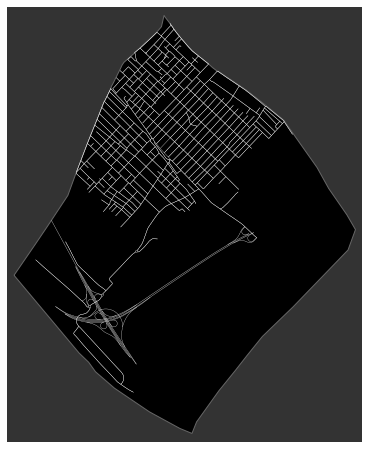

In [ ]:
gdf = ox.geocode_to_gdf('Gyál, Hungary')
G = ox.graph_from_place('Gyál, Hungary', network_type='drive', retain_all=True)

# rajzolja meg a hálózatot, de ne mutassuk meg 
fig, ax = ox.plot_graph(G, show=False, close=False, bgcolor='#333333',
                        edge_color='w', edge_linewidth=0.3, node_size=0)

##  jelölések matplotlib tengelyéhez, hozzá adja a hely alakját sokszögű foltokként
for geometry in gdf['geometry'].tolist():
    if isinstance(geometry, (Polygon, MultiPolygon)):
        if isinstance(geometry, Polygon):
            geometry = MultiPolygon([geometry])
        for polygon in geometry:
            patch = PolygonPatch(polygon, fc='k', ec='#666666', lw=1, alpha=1, zorder=-1)
            ax.add_patch(patch)

## opcionálisan állítsa be a tengelyhosszokat
margin = 0.02
west, south, east, north = gdf.unary_union.bounds

margin_ns = (north - south) * margin
margin_ew = (east - west) * margin

ax.set_ylim((south - margin_ns, north + margin_ns))
ax.set_xlim((west - margin_ew, east + margin_ew))

plt.show()

---

### Vizi utvonalak

---

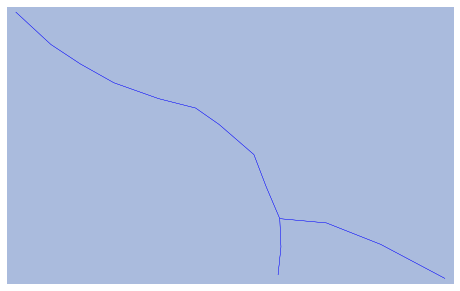

In [ ]:
## Vizi utvonalak megjelenítése
place = 'Szeged, Hungary'
G = ox.graph_from_place(place, custom_filter='["waterway"~"canal"]')
fig, ax = ox.plot_graph(G, bgcolor='#aabbdd', edge_color='b', edge_linewidth=0.3, node_size=0)

---

### Képi adatok, utca hálózat

---

In [ ]:
import osmnx as ox
from IPython.display import Image
%matplotlib inline
ox.config(log_console=True, use_cache=True)
## konfigurálása a inline image display
img_folder = 'images'
extension = 'png'
size = 240
dpi = 40

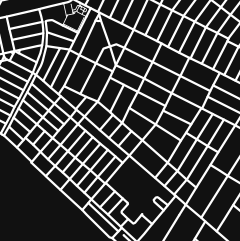

In [ ]:
place = 'sf'
point =  (47.4274747,19.2058965) ## Budapest, Kézdivásárhely utca 9
fp = f'./{img_folder}/{place}.{extension}'
fig, ax = ox.plot_figure_ground(point=point, filepath=fp, dpi=dpi, save=True, show=False, close=True)
Image(fp, height=size, width=size)

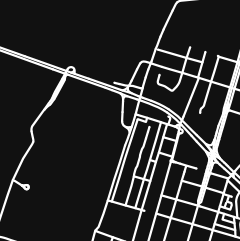

In [ ]:
point =  (47.534675,19.058536) ## Árpád híd
fp = f'./{img_folder}/{place}.{extension}'
fig, ax = ox.plot_figure_ground(point=point, network_type='drive', filepath=fp, dpi=dpi, save=True, show=False, close=True)
Image(fp, height=size, width=size)

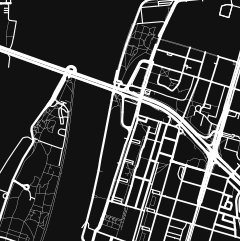

In [ ]:
street_widths = {'footway' : 0.5,
                 'steps' : 0.5,
                 'pedestrian' : 0.5,
                 'path' : 0.5,
                 'track' : 0.5,
                 'service' : 2,
                 'residential' : 3,
                 'primary' : 5,
                 'motorway' : 6}
place = 'sf-custom'
point = (47.534675,19.058536) ## Árpád híd
fp = f'./{img_folder}/{place}.{extension}'
fig, ax = ox.plot_figure_ground(point=point, filepath=fp, network_type='all', street_widths=street_widths,
                                dpi=dpi, save=True, show=False, close=True)
Image(fp, height=size, width=size)

---

### Magasság értékek megjelenítése

---

In [ ]:
# Magasság értékekk hozzáadása
# Google API key szükséges ehhez!!!
from keys import google_elevation_api_key
G = ox.add_node_elevations(G, api_key=google_elevation_api_key)
G = ox.add_edge_grades(G)
nc = ox.plot.get_node_colors_by_attr(G, 'elevation', cmap='plasma')
fig, ax = ox.plot_graph(G, node_color=nc, node_size=20, edge_linewidth=2, edge_color='#333')

---

## Helység térképen történő keresése

finomitó jellegű keresés összeállításával

---

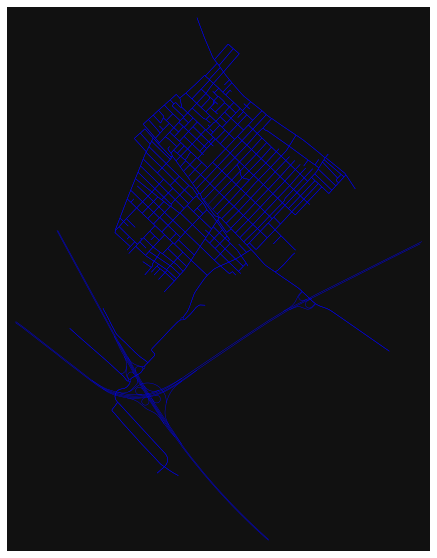

In [ ]:
# finomitó lekérdezés összeállítás
place = {'city'   : 'Gyál',
         'state'  : 'Pest',
         'country': 'Hungary'}
G = ox.graph_from_place(place, network_type='drive', truncate_by_edge=True)
fig, ax = ox.plot_graph(G, figsize=(10, 10), node_size=0, edge_color='b', edge_linewidth=0.4)

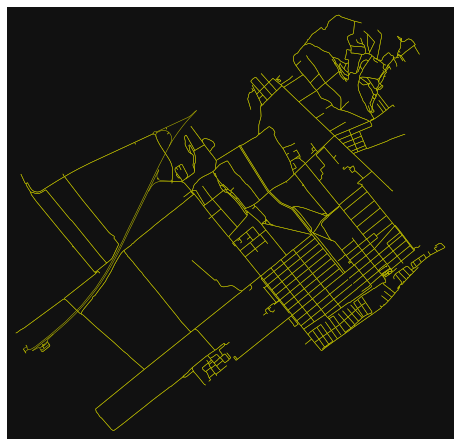

In [ ]:
# Tárnok község kiválasztása
G = ox.graph_from_place('Tárnok, Hungary', network_type='all')
fig, ax = ox.plot_graph(G, node_size=0, edge_color='y', edge_linewidth=0.5)

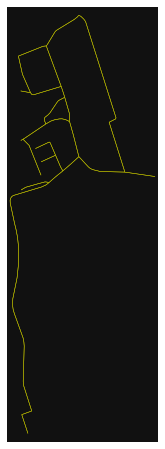

In [ ]:
#Ha csak a poziciót tudjuk akkor a távolság megadásával is kérhetünk térkép adatokat
wurster_hall = (47.3681187,18.7689793) ## Tárnok vasulállomás
one_mile = 2500                        ## méter
G = ox.graph_from_point(wurster_hall, dist=one_mile, network_type='drive')
fig, ax = ox.plot_graph(G, node_size=0, edge_color='y', edge_linewidth=0.5)

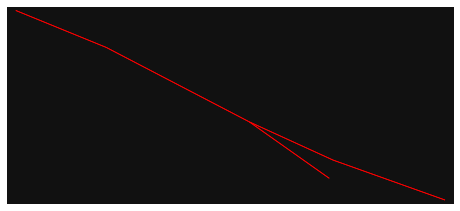

In [ ]:
## Vonat vonal megjelenítése
G = ox.graph_from_place('Kispest, Budapest, Hungary',
                        retain_all=False, truncate_by_edge=True, simplify=True,
                        custom_filter='["railway"~"subway"]')

fig, ax = ox.plot_graph(G, node_size=0, edge_color='r', edge_linewidth=0.8)

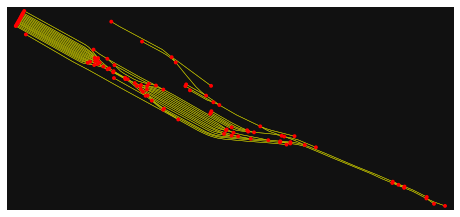

In [ ]:
G = ox.graph_from_place('Budapest, Hungary',
                        retain_all=False, truncate_by_edge=True, simplify=True,
                        custom_filter='["railway"~"subway"]')

fig, ax = ox.plot_graph(G, edge_color='y', node_color='r', edge_linewidth=0.5)

---

## Érdekes helyek keresése

---

In [ ]:
# minden érdekes hely kikeresése
tags = {'amenity' : True,
        'landuse' : ['retail', 'commercial'],
        'highway' : 'bus_stop'}
gdf = ox.pois_from_place('Budapest, Hungary', tags)
gdf.shape


(30816, 864)

In [ ]:
# Bankok listázása
G1= gdf[gdf['amenity']=='bank'].dropna(axis=1, how='any')
##fig, ax = ox.plot_graph(G1, node_size=0, edge_color='r', edge_linewidth=0.2)

In [ ]:
# busz megállók listája
gdf[gdf['highway']=='bus_stop'].dropna(axis=1, how='any').head()

,osmid,geometry,element_type,highway
84640378,84640378,POINT (19.00488 47.46213),node,bus_stop
149662580,149662580,POINT (19.00551 47.43063),node,bus_stop
149663268,149663268,POINT (19.00145 47.42595),node,bus_stop
149663603,149663603,POINT (18.99979 47.42592),node,bus_stop
151134474,151134474,POINT (19.03209 47.44188),node,bus_stop


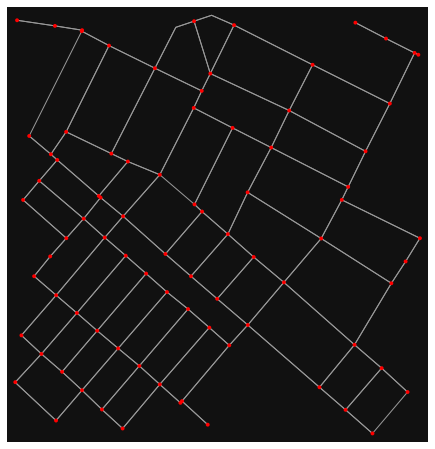

In [ ]:
location_point =  (47.4274747,19.2058965) ## Budapest, Kézdivásárhely utca 9

# térkép megjelenitése pozició és távolság megadásával minden utkereszteződéssel
G = ox.graph_from_point(location_point, dist=500,   dist_type='bbox', network_type='drive')
fig, ax = ox.plot_graph(G, node_color='r')

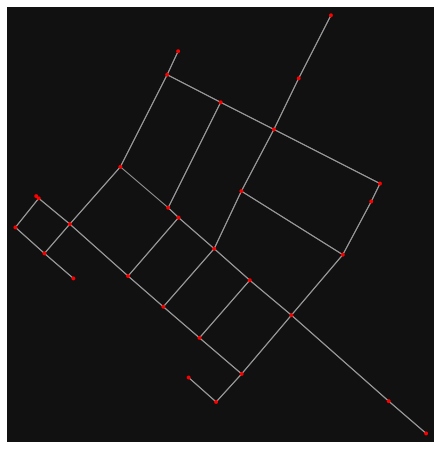

In [ ]:
# megadott ponttol megadott tábvolságon belül lévő pontokból épít hálozatot (térképet)
G = ox.graph_from_point(location_point, dist=500, dist_type='network')
fig, ax = ox.plot_graph(G, node_color='r')

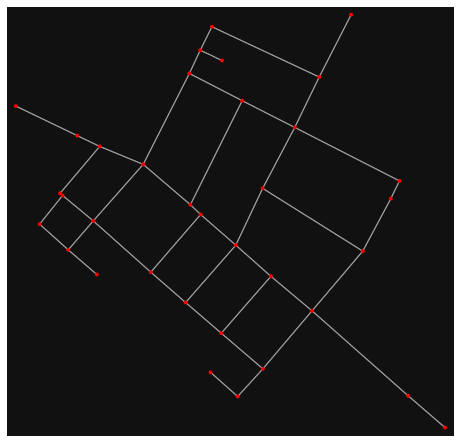

In [ ]:
## gyalogos forgalmú utakkal
G = ox.graph_from_point(location_point, dist=500, dist_type='network', network_type='walk')
fig, ax = ox.plot_graph(G, node_color='r')


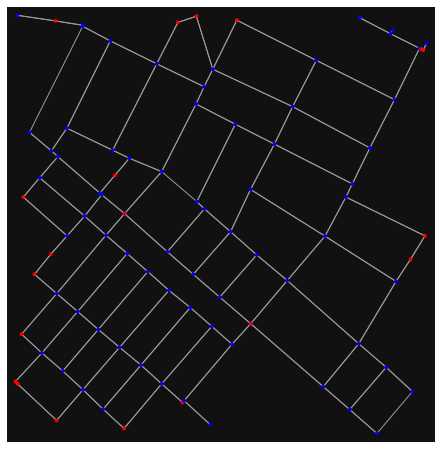

In [ ]:
location_point = (47.4274747,19.2058965) ## Budapest, Kézdivásárhely utca 9
G = ox.graph_from_point(location_point, network_type='drive_service', dist=500, simplify=False)

nc = ['b' if ox.simplification._is_endpoint(G, node) else 'r' for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_color=nc)

---

## Egyszerűsített hálózat ábrázolása, hosszak jelzése színezéssel

---

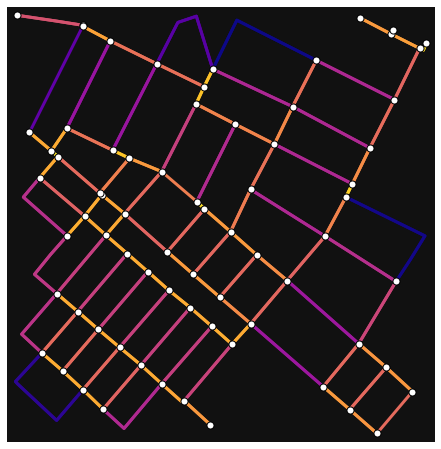

In [ ]:
G = ox.simplify_graph(G)
ec = ox.plot.get_edge_colors_by_attr(G, attr='length', cmap='plasma_r')
fig, ax = ox.plot_graph(G, node_color='w', node_edgecolor='k', node_size=50,
                        edge_color=ec, edge_linewidth=3)

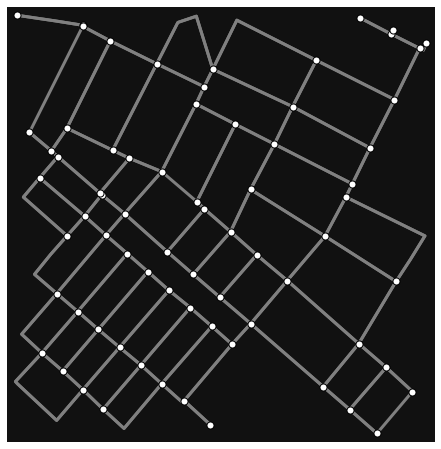

In [ ]:
ec = ['gray' if k == 0 or u == v else 'r' for u, v, k in G.edges(keys=True)]
fig, ax = ox.plot_graph(G, node_color='w', node_edgecolor='k', node_size=50,
                        edge_color=ec, edge_linewidth=3)

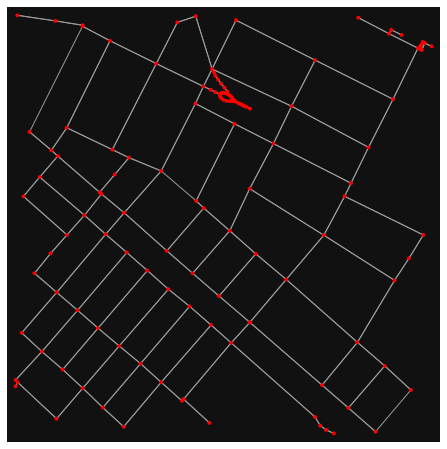

In [ ]:
G = ox.graph_from_point(location_point, dist=500, simplify=False)
fig, ax = ox.plot_graph(G, node_color='r')

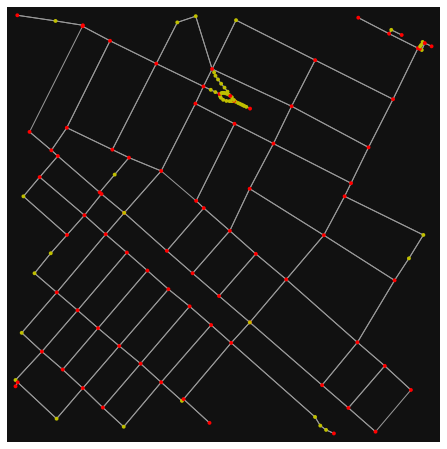

In [ ]:
## Használhatunk egyszerűsítést a csomópontok megtisztításához, amelyek nem kereszteződések vagy zsákutcák
nc = ['r' if ox.simplification._is_endpoint(G, node) else 'y' for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_color=nc)

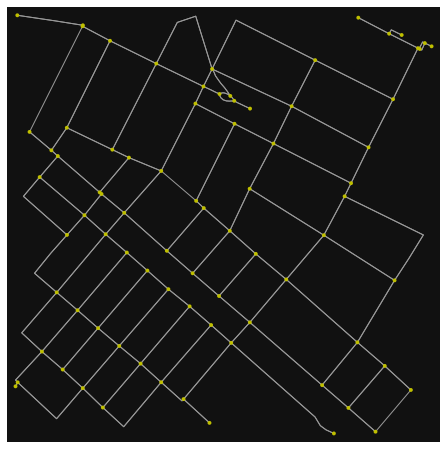

In [ ]:
## egyszerűsítések és hurok mentesítés aktíválása
G2 = ox.simplify_graph(G)
loops = [edge[0] for edge in nx.selfloop_edges(G2)]
nc = ['r' if node in loops else 'y' for node in G2.nodes()]
fig, ax = ox.plot_graph(G2, node_color=nc)

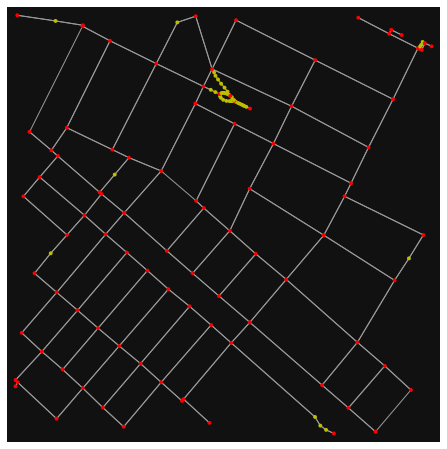

In [ ]:
## egyszerűsítés visszavonása
nc = ['r' if ox.simplification._is_endpoint(G, node, strict=False) else 'y' for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_color=nc)

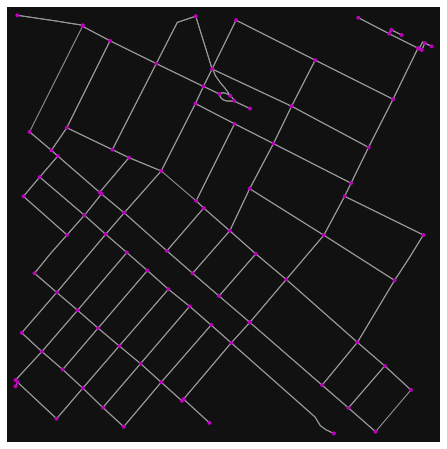

In [ ]:
G3 = ox.simplify_graph(G.copy(), strict=False)
fig, ax = ox.plot_graph(G3, node_color='m')

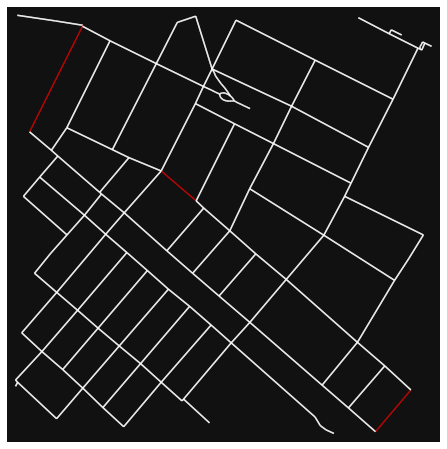

In [ ]:
## egyírányú utak jelőlése (piros színnel)
ec = ['r' if data['oneway'] else 'w' for u, v, key, data in G.edges(keys=True, data=True)]
fig, ax = ox.plot_graph(G, node_size=0, edge_color=ec, edge_linewidth=1.5, edge_alpha=0.7)

#G.edges(keys=True, data=True)
#for u, v, key, data in G.edges(keys=True, data=True):
#    print( data['oneway'] )
#    

---

### Azonos távolságu területek jelőlése szinezéssel

---

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
from descartes import PolygonPatch
from shapely.geometry import Point, LineString, Polygon
%matplotlib inline
ox.config(log_console=True, use_cache=True)

place = 'Óbuda, Budapest, Hungary'
network_type = 'walk'
trip_times = [5, 10, 15, 20, 25]    # idő percben
travel_speed = 4.5                  # gyaloglás sebessége km/hour

G = ox.graph_from_place(place, network_type=network_type)

gdf_nodes = ox.graph_to_gdfs(G, edges=False)
x, y = gdf_nodes['geometry'].unary_union.centroid.xy
center_node = ox.get_nearest_node(G, (y[0], x[0]))
G = ox.project_graph(G)

meters_per_minute = travel_speed * 1000 / 60 #km per hour to m per minute
for u, v, k, data in G.edges(data=True, keys=True):
    data['time'] = data['length'] / meters_per_minute
    
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap='plasma', start=0, return_hex=True)

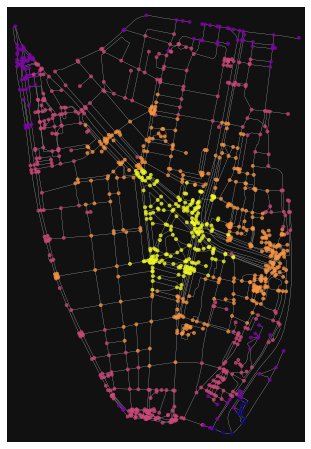

In [ ]:
## Megjelenítés
node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')
    for node in subgraph.nodes():
        node_colors[node] = color
nc = [node_colors[node] if node in node_colors else 'none' for node in G.nodes()]
ns = [15 if node in node_colors else 0 for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_color=nc, node_size=ns, node_alpha=0.8,
                        edge_linewidth=0.2, edge_color='#999999')

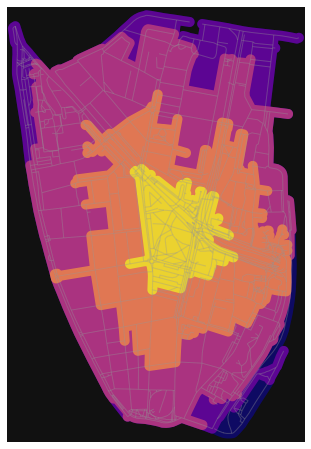

In [ ]:
## megjelenítés 2.
def make_iso_polys(G, edge_buff=25, node_buff=50, infill=False):
    isochrone_polys = []
    for trip_time in sorted(trip_times, reverse=True):
        subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')

        node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
        nodes_gdf = gpd.GeoDataFrame({'id': subgraph.nodes()}, geometry=node_points)
        nodes_gdf = nodes_gdf.set_index('id')

        edge_lines = []
        for n_fr, n_to in subgraph.edges():
            f = nodes_gdf.loc[n_fr].geometry
            t = nodes_gdf.loc[n_to].geometry
            edge_lookup = G.get_edge_data(n_fr, n_to)[0].get('geometry',  LineString([f,t]))
            edge_lines.append(edge_lookup)

        n = nodes_gdf.buffer(node_buff).geometry
        e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
        all_gs = list(n) + list(e)
        new_iso = gpd.GeoSeries(all_gs).unary_union
        
        # try to fill in surrounded areas so shapes will appear solid and blocks without white space inside them
        if infill:
            new_iso = Polygon(new_iso.exterior)
        isochrone_polys.append(new_iso)
    return isochrone_polys

isochrone_polys = make_iso_polys(G, edge_buff=25, node_buff=0, infill=True)
fig, ax = ox.plot_graph(G, show=False, close=False, edge_color='#999999', edge_alpha=0.2, node_size=0)
for polygon, fc in zip(isochrone_polys, iso_colors):
    patch = PolygonPatch(polygon, fc=fc, ec='none', alpha=0.7, zorder=-1)
    ax.add_patch(patch)
plt.show()

---  

## Térkép mentése állományba

---

In [ ]:
# Az utca térkép mentése GeoPackage formátumba  GIS munkához
ox.save_graph_geopackage(G, filepath='BP18_network.gpkg')

In [ ]:
# Az utca térkép mentése GraphML formátumba OSMnx vagy networkx vagy gephi munkához
ox.save_graphml(G, filepath='BP18_network.graphml')


In [ ]:
# Az utca térkép mentése shapefilek könyvtárba  (több állomány képződik)
ox.save_graph_shapefile(G, filepath='BP18_network_dir')

In [ ]:
# Az utca térkép mentése SVG formátumba
fig, ax = ox.plot_graph(G, show=False, save=True, close=True, filepath='gyal.svg')

In [ ]:
# Az utca térkép mentése pontok mentése a geopackage formátumba geopandas használathoz
gdf = ox.pois_from_place(place, tags={'amenity':True})
gdf = gdf.apply(lambda c: c.astype(str) if c.name != 'geometry' else c, axis=0)
gdf.to_file('gyal_pois.gpkg', driver='GPKG')

In [ ]:
# Az utca térkép épületek mentése geopackage formátumba geopandas használathoz
gdf = ox.footprints_from_place(place)
gdf = gdf.apply(lambda c: c.astype(str) if c.name != 'geometry' else c, axis=0)
gdf.to_file('gyal_building_footprints.gpkg', driver='GPKG')

In [ ]:
# Az utca térkép mentése .osm xml file formátumba
ox.config(all_oneway=True, log_console=True, use_cache=True)
G = ox.graph_from_place('Gyál, Hungary', network_type='drive')
ox.save_graph_xml(G, filepath='gyal.osm')

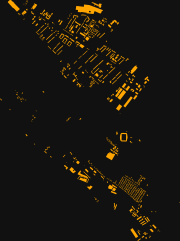

In [ ]:
import matplotlib.pyplot as plt
import osmnx as ox
from IPython.display import Image
%matplotlib inline
ox.config(log_console=True, use_cache=True)

img_folder = 'images'
extension = 'png'
size = 240

gdf = ox.footprints.footprints_from_place(place='Kispest, Budapest, Hungary')
gdf_proj = ox.project_gdf(gdf)
fp = f'./{img_folder}/Bp10_bldgs.{extension}'
fig, ax = ox.plot_footprints(gdf_proj, filepath=fp, dpi=40, save=True, show=False, close=True)
Image(fp, height=size, width=size)



In [ ]:
# Mentés shapefile
gdf.drop(labels='nodes', axis=1).to_file('BP10_bldgs.gpkg', driver='GPKG')

---

## Térkép betőltése állományból

---

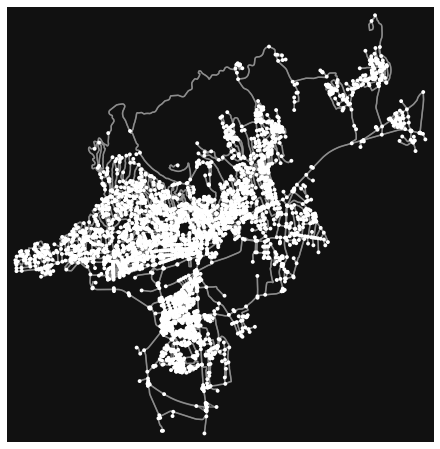

In [ ]:
G = ox.load_graphml(filepath='gyal.graphml')
fig, ax = ox.plot_graph(G, edge_linewidth=1.5, edge_alpha=0.7)

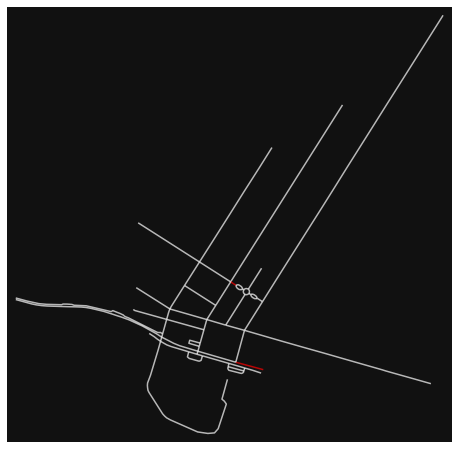

In [ ]:
## Térkép betöltése osm extract fileből
G = ox.graph_from_xml('West-Oakland.osm.bz2')
fig, ax = ox.plot_graph(G, node_size=0, edge_color=ec, edge_linewidth=1.5, edge_alpha=0.7)

---

### interactiv leaflet web maps megjelenítés

---

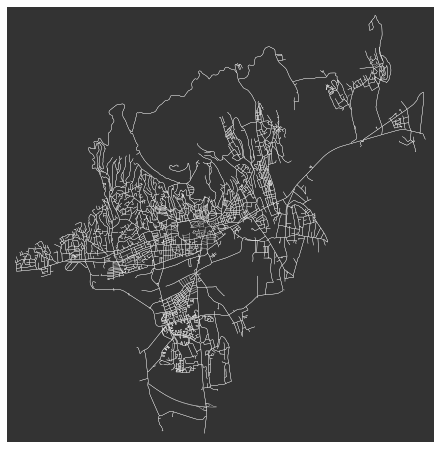

In [ ]:
import networkx as nx
import osmnx as ox
from IPython.display import IFrame
%matplotlib inline
ox.config(log_console=True, use_cache=True)

G = ox.graph_from_place('Pécs, Hungary', network_type='drive')

graph_map = ox.plot_graph_folium(G, popup_attribute='name', edge_width=2)
fig, ax = ox.plot_graph(G, bgcolor='#333333', edge_color='w', edge_linewidth=0.3, node_size=0)


In [ ]:
## Mentés html file-be és megjelenítés  iframe-ben
filepath = 'graph.html'
graph_map.save(filepath)
IFrame(filepath, width=600, height=500)

In [ ]:
# Használjuk a networkx modult számoláshoz a legrővidebb ú kiszámításhoz (két csomopont/node között)

origin_node = list(G.nodes())[0]
destination_node = list(G.nodes())[-1]
route = nx.shortest_path(G, origin_node, destination_node)

route_map = ox.plot_route_folium(G, route)

filepath = 'route.html'
route_map.save(filepath)
IFrame(filepath, width=600, height=500)

In [ ]:
## egyesítsük az előző lépéseket
route_graph_map = ox.plot_route_folium(G, route, route_map=graph_map, popup_attribute='length')

filepath = 'route_graph.html'
route_graph_map.save(filepath)

IFrame(filepath, width=600, height=500)